# **WestGate**


---

This is the implementation of the *Facial Keypoints Detection* network described in the paper available at https://github.com/niccolovettorello1997/VCS

Mount Google Drive in order to read stored data programmatically.

For this operation to work correctly you have:

*   To grant all necessary permissions for your Google Drive account;
*   Save the test file on your Google Drive with path `/vcs/test.csv`
*   Save the training file on your Google Drive with path `/vcs/training.csv`

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Import all necessary libraries.

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

Check if the current runtime is connected to a GPU. If not, raise an error.

Refer to https://colab.research.google.com/notebooks/gpu.ipynb for more info.

In [5]:
# Is the GPU enabled for the current runtime?

if tf.test.gpu_device_name() != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('GPU is enabled for this runtime!')

GPU is enabled for this runtime!


Set the NumPy random seed to a certain value, in order to get consistent results over separate runs.

In [6]:
seed = 1622
np.random.seed(seed) 

Define a series of utility functions.

In [7]:
# Return the DataFrame created by reading the training set.
def get_complete_training_dataframe():
    return pd.read_csv('/content/gdrive/My Drive/vcs/training.csv')
    
# Return the DataFrame created by reading the test set.
def get_test_dataframe():
    return pd.read_csv('/content/gdrive/My Drive/vcs/test.csv')

# Drop all records with at least one null value and return the new DataFrame.
def drop_incomplete_records(df):
    return df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)

# Return the NumPy array of normalized images which have been extracted from the
# DataFrame.
def get_images(df):
    images = df['Image']

    images_list = []
    
    # Split values on separator an build a 2D matrix representing the image
    # Append the newly constructed matrix to the accumulator list
    for img in images:
        images_list.append(np
                           .array([int(x) for x in img.split(' ')])
                           .reshape((96, 96)))
    
    # Normalize every pixel value
    return np.array(images_list) / 255.0

# Delete image row and return the DataFrame composed only by the keypoints
# coordinates.
def drop_image_column(df):
    return df.drop(['Image'], axis=1)

# Show image and keypoints at given index.
def show_image(images_dataset, keypoints_dataset, index): 
    img = np.array(images_dataset[index]).reshape((96, 96))
    keypoints = keypoints_dataset[index]

    x_keypoints = keypoints[::2]
    y_keypoints = keypoints[1::2]

    # Show image
    plt.imshow(img, cmap='gray')
    # Show keypoints on top of image
    plt.scatter(x_keypoints, y_keypoints)
    plt.show()


Process data with the newly defined utility functions in order to compute the training dataset.

In [11]:
# Get training DataFrame
complete_training_dataframe = get_complete_training_dataframe()

# Drop records which have at least one null value
training_dataframe = drop_incomplete_records(complete_training_dataframe)

# Extract images from training DataFrame
training_images = get_images(training_dataframe)
# Extract keypoints DataFrame from training DataFrame
training_dataframe_keypoints = drop_image_column(training_dataframe)

# Convert the DataFrame of training keypoints into an array
training_array_keypoints = training_dataframe_keypoints.to_numpy(
    dtype='float32', 
    copy=False)

# Create the final training array
training_dataset = np.concatenate(
    (
        training_images.reshape((2140, 96 * 96)),
        training_array_keypoints),
    axis=1)

# Shuffle the dataset
np.random.shuffle(training_dataset)

# Get final training images array
images = training_dataset[:, :9216].reshape(2140, 96, 96, 1)

# Get final keypoints array
keypoints = training_dataset[:, 9216:]

Show an image at a certain index with relative keypoints.

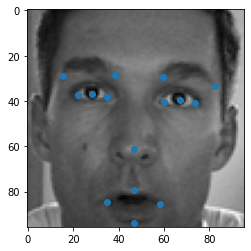

In [12]:
show_image(images, keypoints, 1624)

Define *Convolutional Neural Network* model.

In [13]:
# Returns the CNN model used for Facial Keypoints Detection.
def create_model():
    model = tf.keras.models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(96, 96, 1)),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.ReLU(),
        layers.Dense(96),
        layers.ReLU(),
        layers.Dense(64),
        layers.ReLU(),
        layers.Dense(30)
    ])
    
    return model

Create the model, configure it for training defining the optimizer, the preferred loss function and the metrics used and start training it.

Note that the best configuration found is saved on a file by means of a callback.

In [14]:
model = create_model()

# Setup model for training
model.compile(optimizer='adam',
              loss='huber_loss',
              metrics=['accuracy'])

# Creates a callback to save weights
model_checkpoint_path = "checkpoint01/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_weights_only=True,
    verbose=1)

# Train the model
history = model.fit(images, keypoints, batch_size=32, epochs=100, callbacks=[model_checkpoint_callback])

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 15.9355 - accuracy: 0.2369
Epoch 00001: saving model to checkpoint01/cp.ckpt
67/67 [==============================] - 13s 54ms/step - loss: 15.9355 - accuracy: 0.2369
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 4.2230 - accuracy: 0.5832
Epoch 00002: saving model to checkpoint01/cp.ckpt
67/67 [==============================] - 4s 53ms/step - loss: 4.2230 - accuracy: 0.5832
Epoch 3/100
66/67 [============================>.] - ETA: 0s - loss: 1.6579 - accuracy: 0.6837
Epoch 00003: saving model to checkpoint01/cp.ckpt
67/67 [==============================] - 3s 50ms/step - loss: 1.6571 - accuracy: 0.6822
Epoch 4/100
66/67 [============================>.] - ETA: 0s - loss: 1.4972 - accuracy: 0.6766
Epoch 00004: saving model to checkpoint01/cp.ckpt
67/67 [==============================] - 3s 52ms/step - loss: 1.4960 - accuracy: 0.6766
Epoch 5/100
66/67 [============================>.] - ETA: 0s - lo

Define a function to show an image with the corresponding predicted keypoints.

In [15]:
# Shows predicted keypoints on image
def show_resulting_image(predictions, index):
    resulting_keypoints = predictions[index, :]
    
    x_values = resulting_keypoints[::2]
    y_values = resulting_keypoints[1::2]
    
    image = images[index].reshape(96, 96)

    plt.imshow(image, cmap='gray')
    plt.scatter(x_values, y_values)
    plt.show()

Get images from test DataFrame.

In [16]:
test_dataframe = get_test_dataframe()
test_images = get_images(test_dataframe).reshape(1783, 96, 96, 1)

Use model to predict keypoints, then show them on the corresponding image.

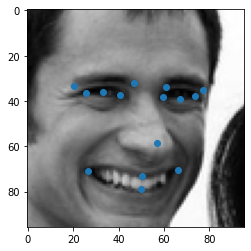

In [18]:
predictions = model.predict(images)
show_resulting_image(predictions, 1361)